In [396]:
# Show the figures / plots inside the notebook
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from mpl_toolkits.mplot3d import Axes3D
import scipy.misc
from skimage.color import rgb2gray,rgb2hsv


face_cascade = cv2.CascadeClassifier('./haar/haarcascade_frontalface_default.xml')
mouth_cascade = cv2.CascadeClassifier('./haar/haarcascade_smile.xml')


# if mouth_cascade.empty():
#   raise IOError('Unable to load the mouth cascade classifier xml file')



Utility functions

In [397]:
def show_hist(image, title, ignore_first=1, original_image=None):
    """
    This is a helper function to plot a histogram of an image using matplotlib
    """
    # Calculate the histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist[0:ignore_first] = 0
    if original_image is not None:
        peaks_indices, hist = get_peaks(hist, original_image)
    else:
        peaks_indices, hist = get_peaks(hist, image)
    print(peaks_indices)
    # Ignore the first 'ignore_first' values in the histogram
    

    # Plot the modified histogram
    plt.plot(hist, color='black')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

def show_image_3d(image):
    """
    This is a helper function to plot a 3D plot of the image
    """
    # Create the x and y coordinate arrays (here we just use pixel indices)
    xx, yy = np.mgrid[0:image.shape[0], 0:image.shape[1]]

    # Flatten xx and yy
    x_flat = xx.ravel()
    y_flat = yy.ravel()

    # Get the values for each pixel
    intensity = image.ravel()

    # Setup a figure and axes
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the values
    ax.scatter(x_flat, y_flat, intensity, c=intensity, cmap='viridis')

    plt.show()
    

def remove_background(image, rectangle, iterations=5):
    """
    This is a helper function to use grabCut to remove the background from an image
    """
    #This line creates an empty binary mask with the same dimensions as the input image 
    #The mask is initially filled with zeros, indicating that no pixels are currently classified as either foreground or background.
    mask = np.zeros(image.shape[:2], np.uint8)
    cv2.grabCut(image, mask, rectangle, None, None, iterations, cv2.GC_INIT_WITH_RECT)

    #if mask is 2 or 0, it is converted to 0, otherwise converted to 1
    #2 or 0 means background, 1 or 3 means foreground
    mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    #converting the input image to grayscale and applying the mask
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = img * mask

    return img

def divide_image(image):
    """
    This is a helper function to divide an image into 4 parts
    """
    img = image.copy()

    #this function takes an image and divide it into 4 parts
    part1 = img[0:img.shape[0]//2, 0:img.shape[1]//2]
    part2 = img[0:img.shape[0]//2, img.shape[1]//2:img.shape[1]]
    part3 = img[img.shape[0]//2:img.shape[0], 0:img.shape[1]//2]
    part4 = image[img.shape[0]//2:img.shape[0], img.shape[1]//2:img.shape[1]]

    return part1, part2, part3, part4

#this function takes an images and divide into 4 parts and calculate the histogram of each part
def local_hist(image):
    """
    This is a helper function that plots the histogram of each part of the image
    """
    part1, part2, part3, part4 = divide_image(image)

    show_hist(part1, 'Histogram of part1', original_image=image)
    show_hist(part2, 'Histogram of part2', original_image=image)
    show_hist(part3, 'Histogram of part3', original_image=image)
    show_hist(part4, 'Histogram of part4', original_image=image)

#this function takes array of threshold values and an image and return the image after applying the threshold to each part
def local_thresholding(thresholds, image):
    """
    This is a helper function that takes an array of threshold values 
    and an image and return the image after applying the threshold to each part
    """
    # Create a copy of the image
    image_thresholded = np.copy(image)

    # Divide the image into 4 parts
    part1 = image_thresholded[0:image.shape[0]//2, 0:image.shape[1]//2]
    part2 = image_thresholded[0:image.shape[0]//2, image.shape[1]//2:image.shape[1]]
    part3 = image_thresholded[image.shape[0]//2:image.shape[0], 0:image.shape[1]//2]
    part4 = image_thresholded[image.shape[0]//2:image.shape[0], image.shape[1]//2:image.shape[1]]

    # Apply thresholding
    image_thresholded[0:image.shape[0]//2, 0:image.shape[1]//2] = np.where(part1 < thresholds[0], 0, 255)
    image_thresholded[0:image.shape[0]//2, image.shape[1]//2:image.shape[1]] = np.where(part2 < thresholds[1], 0, 255)
    image_thresholded[image.shape[0]//2:image.shape[0], 0:image.shape[1]//2] = np.where(part3 < thresholds[2], 0, 255)
    image_thresholded[image.shape[0]//2:image.shape[0], image.shape[1]//2:image.shape[1]] = np.where(part4 < thresholds[3], 0, 255)
    

    return image_thresholded

def get_peaks(hist, image):
    """
    This is a helper function that takes and image and its histogram and return the peaks of the histogram
    """
    
    skin_color = image[0, 0]
    #tooth color is the average color of 5x5 pixels in the middle of the image
    tooth_color = image[(image.shape[0]//2)-40, image.shape[1]//2]
    print("dist here ",tooth_color, skin_color)
    dist = np.abs(np.abs(tooth_color.astype(np.float64)-skin_color.astype(np.float64))-10)
    dist = dist if dist >= 1 else 125

    #Here I am removing delta peaks
    #which are peaks that are much higher than the neighboring point
    hist_suppressed = suppress_delta_peaks(hist, percentage=0.45)

    peaks_indices, _ = find_peaks(hist_suppressed.flatten(), distance=dist, height=0.4*max(hist.flatten()))
    return peaks_indices, hist_suppressed


def get_peaks_local(image):
    """
    This is a helper function that takes an image and returns the peaks of the histogram of each part of the image
    """
    part1, part2, part3, part4 = divide_image(image)

    hist1 = cv2.calcHist([part1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([part2], [0], None, [256], [0, 256])
    hist3 = cv2.calcHist([part3], [0], None, [256], [0, 256])
    hist4 = cv2.calcHist([part4], [0], None, [256], [0, 256])

    peak1, _ = get_peaks(hist1, image)
    peak2, _ = get_peaks(hist2, image)
    peak3, _ = get_peaks(hist3, image)
    peak4, _ = get_peaks(hist4, image)

    return peak1, peak2, peak3, peak4

def get_threshold_between_2_peaks(peak1, peak2, img):
    """
    This is a helper function that takes an image and 2 peaks and returns the threshold between them using Iterative Threshold Selection 
    """
    
    min_value = 255
    min_index = 0
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    
    for i in range(0, peak2-peak1):
        if hist[i] < min_value:
            min_value = hist[i]
            min_index = i

    return min_index + peak1 + 40

def get_max_gap(hist):
    """
    This is a helper function that takes a histogram and returns the index and value of the maximum gap
    """
    max_gap = 0
    max_gap_index = 0
    for i in range(1, len(hist)-1):
        if hist[i] > hist[i-1] and hist[i] > hist[i+1]:
            if hist[i]-hist[i-1] > max_gap and hist[i]-hist[i+1] > max_gap:
                max_gap = hist[i]-hist[i-1]
                max_gap_index = i

    #for the first point
    if hist[0] > hist[1] and hist[0]-hist[1] > max_gap:
        max_gap = hist[0]-hist[1]
        max_gap_index = 0

    #for the last point
    if hist[-1] > hist[-2] and hist[-1]-hist[-2] > max_gap:
        max_gap = hist[-1]-hist[-2]
        max_gap_index = len(hist)-1

    return max_gap, max_gap_index

def suppress_delta_peaks(hist, percentage=0.5):
    """
    This is a helper function that takes a histogram and percentage and returns the histogran after suppressing the delta peaks
    """
    #Here I am removing delta peaks
    #the method is to remove peaks that are much higher than the neighboring peaks
    #I am calculating the difference between each peak and its left and right neighbors
    #if the difference is higher than a threshold, then I am removing this peak
    my_hist = hist.copy()   
    hist_max_gap = get_max_gap(hist)[0]
    threshold = int(hist_max_gap*percentage)

    for i in range(1, len(hist)-1):
        if hist[i] > hist[i-1] and hist[i] > hist[i+1]:
            if hist[i]-hist[i-1] > threshold and hist[i]-hist[i+1] > threshold:
                my_hist[i] = (hist[i-1] + hist[i+1])//2

    return my_hist

def getThreshold(img):
    # img = image.copy()
    # if (len(img.shape) == 3):
    #     img = rgb2gray(img)
    #     img = (img * 255).astype(np.uint8)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    imgHist = hist#calcHist(img)
    T_init = 0
    T = 0
    # Get the initial threshold Tinit (the mean of the image)
    for k in range(256):
        T_init += k*imgHist[k]
    T_init = np.round(T_init / np.sum(imgHist))
    
    # Get the two weighted averages (means), one for the lower pixels (have gray level less than Tinit) and the other for the higher pixels (have gray level more than Tinit)
    while True:
        sum1 = 0
        sum2 = 0
        count1 = 0
        count2 = 0
        for k in range(256):
            if k < T_init:
                sum1 += k*imgHist[k]
                count1 += imgHist[k]
            else:
                sum2 += k*imgHist[k]
                count2 += imgHist[k]
                
        m1 = sum1/ count1
        m2 = sum2/ count2
        
        T = np.round((m1 + m2) / 2)
        if T == T_init:
            break
        else:
            T_init = T
    return int(T)
  

Reading the image and applying face detection using haar cascades

In [398]:
# Read the input image
image_path = './images/img1.jpg'
img = cv2.imread(image_path)

#resize image 716x900
img = cv2.resize(img, (716, 900))

# Perform face detection
faces = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)

# Draw rectangles around the detected faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Display the result
cv2.imshow('Face Detection', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Remove background using Grabcut algorithm


In [399]:
img_temp = img.copy()
# img_temp = remove_background(img, faces[0], iterations=5)

cv2.imshow("Foreground", img_temp)
cv2.waitKey(0)
cv2.destroyAllWindows()

Segmenting the mouth area from the face and applying gamma correction

dist here  98 151
[ 88 133 222]


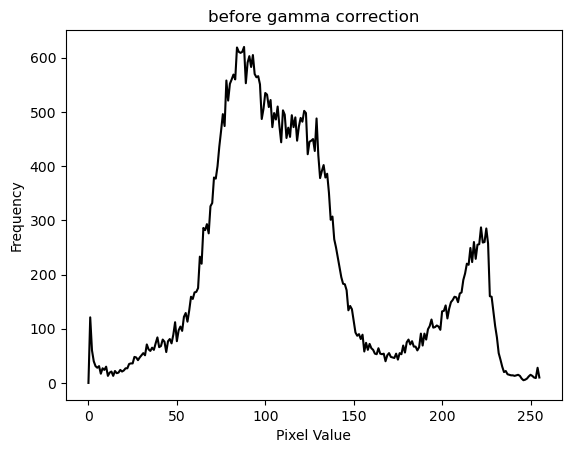

dist here  98 151
[ 88 133 222]


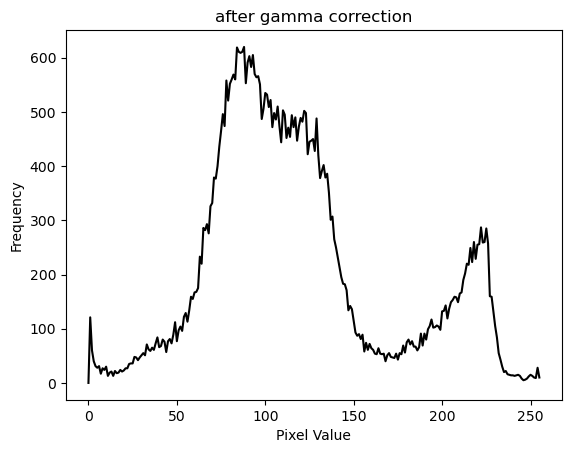

In [400]:
#segment the face
img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2GRAY)
for (x, y, w, h) in faces:
    #take the region of interest which is the face
    roi_gray = img_temp[y:y+h, x:x+w]
    
    #then take the mouth region only
    roi_gray_mouth_region = roi_gray[int(roi_gray.shape[0]/1.5):roi_gray.shape[0], int(roi_gray.shape[1]/4):int(roi_gray.shape[1]/4)+int(roi_gray.shape[1]/2)]

    cv2.imshow('mouth Segmentation before gamma correction', roi_gray_mouth_region)

    #plot histogram
    show_hist(roi_gray_mouth_region, "before gamma correction")
    
    #apply gamma correction
    gamma = 1
    roi_gray_mouth_region = np.array(255 * (roi_gray_mouth_region / 255) ** gamma, dtype = 'uint8')

    #plot histogram
    show_hist(roi_gray_mouth_region, "after gamma correction")
    
    cv2.imshow('mouth Segmentation after gamma correction', roi_gray_mouth_region)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

dist here  98 151
[121]


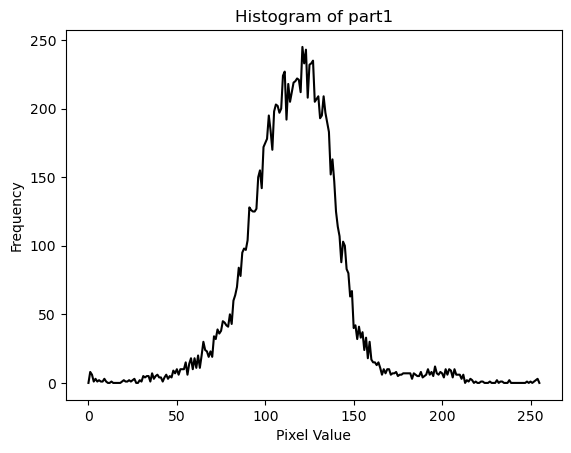

dist here  98 151
[87]


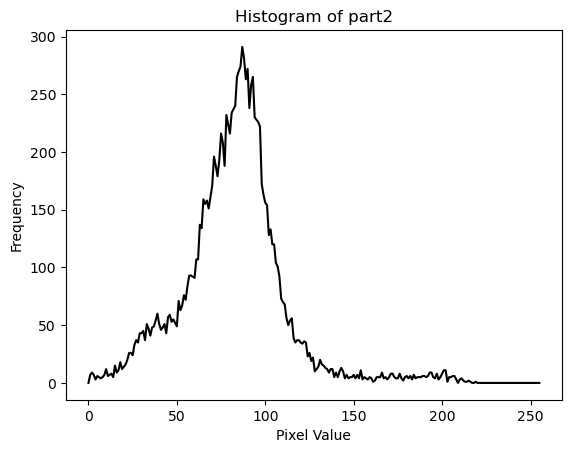

dist here  98 151
[120 226]


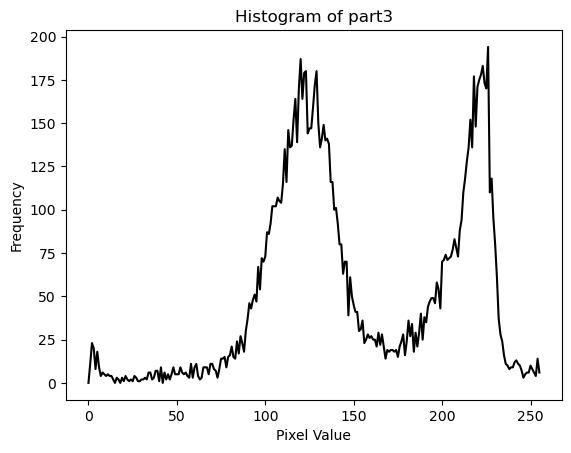

dist here  98 151
[ 80 225]


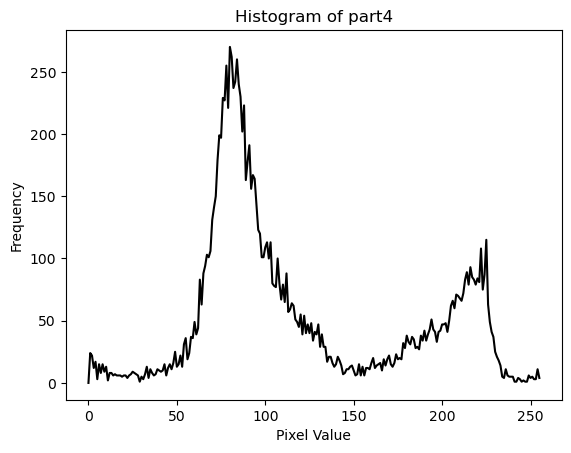

In [401]:
local_hist(roi_gray_mouth_region)

Applying segmentation using threshholding

In [402]:
#dividing the image into 4 parts and calculate the histogram of each part
part1, part2, part3, part4 = divide_image(roi_gray_mouth_region)
peak1, peak2, peak3, peak4 = get_peaks_local(roi_gray_mouth_region)

#puting the peaks in an array to make it easy to loop over them
hist_peaks = [peak1, peak2, peak3, peak4]
img_parts = [part1, part2, part3, part4]

for i in range(len(hist_peaks)):
    #if there is one peak only, then put hist_peaks[i] = 255
    if len(hist_peaks[i]) == 1:
        hist_peaks[i] = 255
    else:
        hist_peaks[i] = get_threshold_between_2_peaks(hist_peaks[i][-2], hist_peaks[i][-1], img_parts[i][0])
        #hist_peaks[i] = getThreshold(img_parts[i][0]) 
        
print(hist_peaks)
roi_gray_mouth_region = local_thresholding(hist_peaks, roi_gray_mouth_region)


cv2.imshow('After Threshholding', roi_gray_mouth_region)
cv2.waitKey(0)
cv2.destroyAllWindows()

dist here  98 151
dist here  98 151
dist here  98 151
dist here  98 151
[255, 255, 162, 120]


Applying opening to remove noise

In [403]:
kernel = np.ones((7, 7), np.uint8)

# Define the dimensions of the ellipse (width and height)
ellipse_width = 10
ellipse_height = 5

# Create an elliptical kernel
ellipse_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ellipse_width, ellipse_height))

# Apply opening operation to the binary mask
opened_mask = cv2.morphologyEx(roi_gray_mouth_region, cv2.MORPH_OPEN, ellipse_kernel, iterations=2)

roi_gray_mouth_region = roi_gray_mouth_region * opened_mask

cv2.imshow("Opened Mask", roi_gray_mouth_region*255)  # Multiply by 255 for better visualization
cv2.waitKey(0)
cv2.destroyAllWindows()

Applying dilation to take the whole mouth

In [404]:
kernel = np.ones((5, 5), np.uint8)

# Define the dimensions of the ellipse (width and height)
ellipse_width = 10
ellipse_height = 5

# Create an elliptical kernel
ellipse_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ellipse_width, ellipse_height))


# Apply closing operation to the binary mask
dilate_mask = cv2.morphologyEx(roi_gray_mouth_region, cv2.MORPH_DILATE, ellipse_kernel, iterations=6)

roi_gray_mouth_region = cv2.bitwise_or(roi_gray_mouth_region, dilate_mask)

cv2.imshow("Opened Mask", roi_gray_mouth_region*255)  # Multiply by 255 for better visualization
cv2.waitKey(0)
cv2.destroyAllWindows()

Apply closing to close gaps

In [405]:
kernel = np.ones((5, 5), np.uint8)

# # Define the dimensions of the ellipse (width and height)
# ellipse_width = 5
# ellipse_height = 10

# # Create an elliptical kernel
# ellipse_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ellipse_width, ellipse_height))


# Apply closing operation to the binary mask
close_mask = cv2.morphologyEx(roi_gray_mouth_region, cv2.MORPH_CLOSE, kernel, iterations=5)
roi_gray_mouth_region = cv2.bitwise_or(roi_gray_mouth_region, close_mask)

cv2.imshow("closemask", roi_gray_mouth_region*255)  # Multiply by 255 for better visualization
cv2.waitKey(0)
cv2.destroyAllWindows()

Plotting in 3d

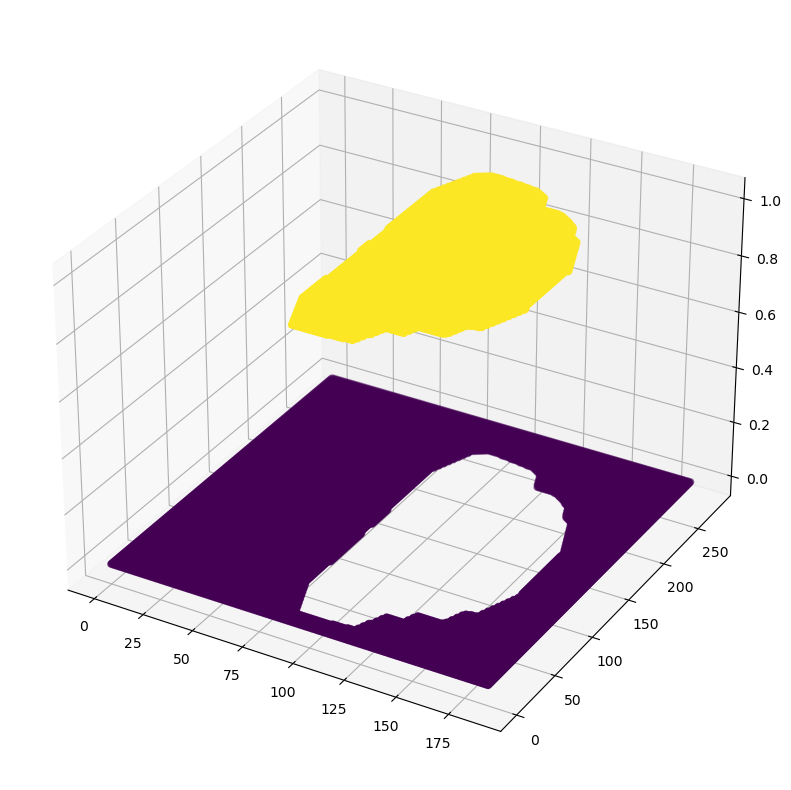

In [406]:
show_image_3d(roi_gray_mouth_region)

Get the mean position of 1's


118.03362194274158 128.80345067307084


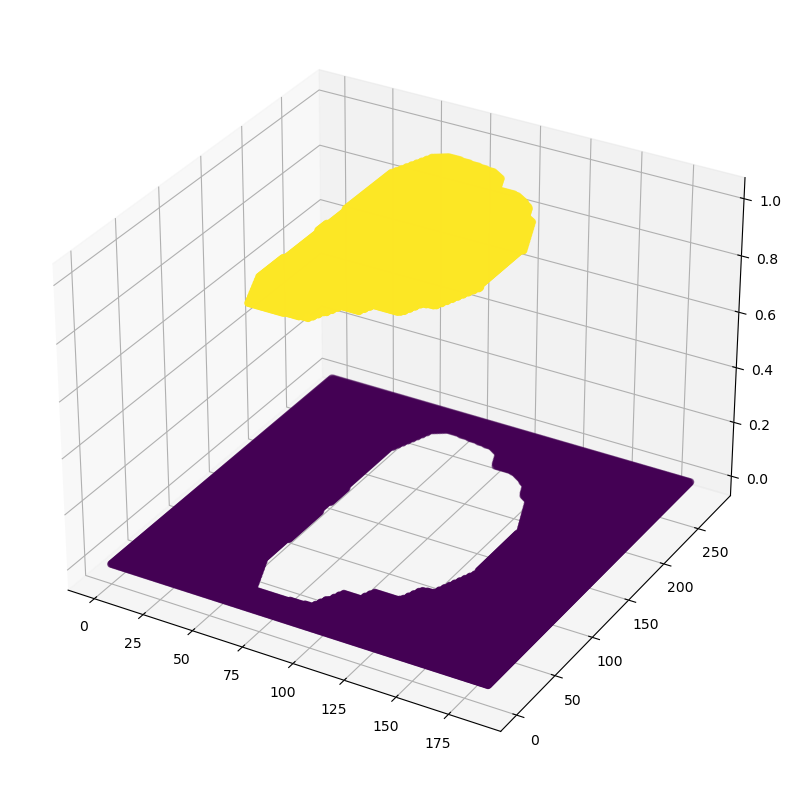

'\nNOTE: the tansalation will not happen on the mask, it has to applied after the mask is applied to the image\nHere I am just showing the translation on the mask to make it easy to understand and analyze\n'

In [407]:
# Find the coordinates of all ones
rows, cols = np.where(roi_gray_mouth_region == 1)

img_center_y = roi_gray_mouth_region.shape[0]//2
img_center_x = roi_gray_mouth_region.shape[1]//2

# Calculate the mean position
mean_row = np.mean(rows)
mean_col = np.mean(cols)

print(mean_row, mean_col)

#I want to shift the image so that the mean position is in the center of the image
shift_x = img_center_x - mean_col
shift_y = img_center_y - mean_row

# Define the translation matrix
translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])

# Translate the mask for anaylsis purposes
img_translation = cv2.warpAffine(roi_gray_mouth_region, translation_matrix, (roi_gray_mouth_region.shape[1], roi_gray_mouth_region.shape[0]))

show_image_3d(img_translation)

"""
NOTE: the tansalation will not happen on the mask, it has to applied after the mask is applied to the image
Here I am just showing the translation on the mask to make it easy to understand and analyze
"""

Take the mouth from the original image

In [408]:
#Now we have the mouth region only
#We want to extract the lips from the orignal image
for (x, y, w, h) in faces:
    
    mouth_region = img[y+int(roi_gray.shape[0]/1.5):y+h, x+int(roi_gray.shape[1]/4):x+int(roi_gray.shape[1]/4)+int(roi_gray.shape[1]/2)] 

    #apply the mask to the mouth region
    #here we convert the mask to 3d to apply it to the mouth region
    #np.stack((roi_gray_mouth_region,) * 3, axis=-1) converts the mask to 3d in the last axis which is the color axis
    roi_gray_mouth_region_3d = np.stack((roi_gray_mouth_region,) * 3, axis=-1)
    mouth_region = mouth_region * roi_gray_mouth_region_3d
   
    cv2.imshow('mouth Segmentation', mouth_region)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Translate image

In [409]:
mouth_region = cv2.warpAffine(mouth_region, translation_matrix, (roi_gray_mouth_region.shape[1], roi_gray_mouth_region.shape[0]))
roi_gray_mouth_region = cv2.warpAffine(roi_gray_mouth_region, translation_matrix, (roi_gray_mouth_region.shape[1], roi_gray_mouth_region.shape[0]))

cv2.imshow('mouth Segmentation', roi_gray_mouth_region*255)

#get left most point in the mask and the right most point and the top most point and the bottom most point
#these points will be used to crop the image

print(roi_gray_mouth_region.shape)
left_most_point = (roi_gray_mouth_region.shape[0], roi_gray_mouth_region.shape[1])
right_most_point = (0, 0)
top_most_point = (roi_gray_mouth_region.shape[0], roi_gray_mouth_region.shape[1])
bottom_most_point = (0, 0)



print(left_most_point)

for i in range(roi_gray_mouth_region.shape[0]):
    for j in range(roi_gray_mouth_region.shape[1]):
        if roi_gray_mouth_region[i][j] == 1:
            if i < left_most_point[0]:
                left_most_point = (i, j)
            if i > right_most_point[0]:
                right_most_point = (i, j)
            if j < top_most_point[1]:
                top_most_point = (i, j)
            if j > bottom_most_point[1]:
                bottom_most_point = (i, j)



print (left_most_point, right_most_point, top_most_point, bottom_most_point)

#crop the image using the points we got
mouth_region = mouth_region[left_most_point[0]:right_most_point[0], top_most_point[1]:bottom_most_point[1]]
roi_gray_mouth_region = roi_gray_mouth_region[left_most_point[0]:right_most_point[0], top_most_point[1]:bottom_most_point[1]]



cv2.imshow('transalation', mouth_region)
cv2.waitKey(0)
cv2.destroyAllWindows()

(187, 279)
(187, 279)
(56, 53) (140, 108) (64, 21) (70, 255)


In [410]:
cv2.imshow('transalation', mouth_region)
cv2.waitKey(0)
cv2.destroyAllWindows()

Loading the second image

In [411]:
image2_path = './images/amin2.png'
img2 = cv2.imread(image2_path)

#resize image 716x900
img2 = cv2.resize(img2, (716, 1000))

##  ##
# Perform face detection
faces2 = face_cascade.detectMultiScale(img2, scaleFactor=1.3, minNeighbors=5)



cv2.imshow('Face Detection 2', img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

Apply the mask to the second image

In [412]:
for (x2, y2, w2, h2) in faces2:

    #take the region of interest which is the face
    roi2 = img2[y2:y2+h2, x2:x2+w2]
    
    #and here I am taking the mouth region only, which will help me to detect the mouth region in the second image using haar
    #haar cascade works better with small images, it doesn't work well with large images
    #so I am taking the mouth region only to detect the mouth region in the second image
    mouth2_region = roi2[int(roi2.shape[0]/1.5):roi2.shape[0], int(roi2.shape[1]/4):int(roi2.shape[1]/4)+int(roi2.shape[1]/2)]

    #using haar cascade to detect the mouth region
    mouth2 = mouth_cascade.detectMultiScale(mouth2_region, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100))

    for (mx2, my2, mw2, mh2) in mouth2:
        cv2.rectangle(mouth2_region, (mx2, my2), (mx2+mw2, my2+mh2), (0, 255, 0), 2)


    [mx2, my2, mw2, mh2] = mouth2[0]
    mouth2_region = mouth2_region[my2:my2+mh2, mx2:mx2+mw2]


    #resize the mouth region to the same size of the mouth region of the second image
    mouth_region_resized = cv2.resize(mouth_region, (mw2, mh2))
    roi_gray_mouth_region_resized = cv2.resize(roi_gray_mouth_region, (mw2, mh2))


    # put the mouth region in the second image
    for i in range(mouth2_region.shape[0]):
        for j in range(mouth2_region.shape[1]):
            if roi_gray_mouth_region_resized[i][j] == 1:
                #blend colors
                mouth2_region[i][j] = mouth_region_resized[i][j]

    # This code is for blending the mouth region in the second image using seamlessClone, but it doesn't work well
    # # Create a mask for the mouth region in the second image
    # mask = np.zeros_like(mouth2_region)

    # # Set the mask for the mouth region
    # mask[int(my2):int(my2 + mh2), int(mx2):int(mx2 + mw2)] = 255

    # location_in_img2 = 

    # # Use seamlessClone to blend the mouth region onto the second image
    # lol = cv2.seamlessClone(mouth_region_resized, img2, mask, (int(mx2 + mw2 / 2), int(my2 + mh2 / 2)), cv2.NORMAL_CLONE)

    # # Display the result
    # cv2.imshow('ResultNEWNEW', lol)



cv2.imshow('mouth2_region', mouth2_region)
cv2.imshow('Result', img2)
cv2.waitKey(0)
cv2.destroyAllWindows()